In [821]:
import pandas as pd
import math

#Read the data in
df = pd.read_csv('backward_all.csv')

In [822]:
#Convert to negative weeks to death, so numbers are in chronological order
df = df.sort_values(by='weeks_to_death', ascending=False)

In [823]:
df.head()

,database,MALE,weeks_to_death,albumin_avg,idwg_percent_avg,pre_sbp_avg,crp_avg,albumin_std,idwg_percent_std,pre_sbp_std,crp_std,albumin_count,idwg_percent_count,pre_sbp_count,crp_count,patient_count
1038,KfH-Europe,1,104,3.799071,3.073809,135.469394,19.576231,0.505016,1.645544,20.260271,29.511232,144,13552,13607,200,4754
830,RRI,1,104,3.871430,3.759100,148.908000,24.150000,0.432270,1.788500,26.539200,4.030500,126,1545,1589,2,564
518,FMC_LA,0,104,3.752380,3.178700,131.393000,NaN,0.341910,2.850800,23.224700,NaN,63,20,229,0,234
310,FMC_EUROPE,0,104,3.765270,3.266300,133.958000,8.983000,0.510960,1.745500,26.435200,16.336900,169,1909,1733,118,801
622,FMC_LA,1,104,3.888690,3.360200,135.858000,NaN,0.433980,2.060000,21.695900,NaN,84,28,310,0,322


In [824]:
# Select var average for FEMALES in FMC_EUROPE
# Get subset of the dataframe to sonify - already sorted by weeks_to_death desc
test_var = df.loc[(df['database'] == 'FMC_EUROPE') & (df['MALE'] == 0), 'pre_sbp_avg']
# alb = df.loc[(df['database'] == 'FMC_EUROPE') & (df['MALE'] == 0), 'albumin_avg']

#take 5 week rolling average, then normalize the values
test_var = test_var.rolling(5).mean()[5:]
test_var = (test_var - test_var.min())/(test_var.max() - test_var.min())

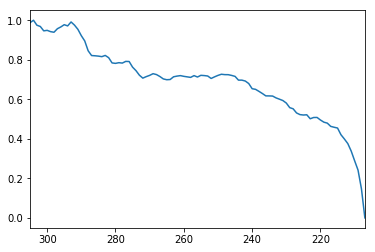

In [825]:
import matplotlib.pyplot as plt

test_var.plot()
plt.show()

In [826]:
test_var

305    0.987833
304    1.000000
303    0.974897
302    0.968391
301    0.946336
300    0.948872
299    0.942314
298    0.939291
297    0.957145
296    0.966136
295    0.977510
294    0.971388
293    0.991265
292    0.975358
291    0.953969
290    0.921847
289    0.895284
288    0.845539
287    0.821435
286    0.820231
285    0.818515
284    0.815800
283    0.821999
282    0.810600
281    0.784113
280    0.781834
279    0.785292
278    0.783319
277    0.791824
276    0.791209
         ...   
236    0.617383
235    0.617203
234    0.616460
233    0.607162
232    0.600579
231    0.593740
230    0.581086
229    0.557878
228    0.551986
227    0.531059
226    0.522606
225    0.520556
224    0.521760
223    0.501678
222    0.507979
221    0.508287
220    0.495248
219    0.484387
218    0.479546
217    0.463127
216    0.458644
215    0.454674
214    0.420861
213    0.399267
212    0.376137
211    0.338021
210    0.289198
209    0.241681
208    0.146776
207    0.000000
Name: pre_sbp_avg, Lengt

In [827]:
# Config
BPM = 120 # Beats per minute, e.g. 60, 75, 100, 120, 150
DIVISIONS_PER_BEAT = 4 # e.g. 4 = quarter notes, 8 = eighth notes
VARIANCE_MS = 20 # +/- milliseconds an instrument note should be off by to give it a little more "natural" feel
VARIANCE_RATE = 0 # for adding variance to the playback rate
# ROUND_TO_NEAREST * DIVISIONS_PER_BEAT = BEAT_MS
# ms per divided beats * number of divided beats = ms in a beat
BEAT_MS = round(60.0 / BPM * 1000) # ms in a beat - 500
ROUND_TO_NEAREST = round(BEAT_MS/DIVISIONS_PER_BEAT) # beat (measure) over divisions per beat (time signature) - 125

INSTRUMENTS_INPUT_FILE = 'son_instruments.csv'
REPORT_SUMMARY_OUTPUT_FILE = 'reports/report_summary.csv'
REPORT_SEQUENCE_OUTPUT_FILE = 'reports/report_sequence.csv'
INSTRUMENTS_OUTPUT_FILE = 'data/chk_instruments.csv'
SEQUENCE_OUTPUT_FILE = 'data/chk_sequence.csv'
INSTRUMENTS_DIR = 'instruments/'

In [828]:
#For getting pseudo-random numbers
def halton(index, base):
    result = 0.0
    f = 1.0 / base
    i = 1.0 * index
    while(i > 0):
        result += f * (i % base)  
        i = math.floor(i / base)
        f = f / base
    return result

#Round n to the nearest nearest
def roundToNearest(n, nearest):
    return 1.0 * round(1.0*n/nearest) * nearest

In [829]:
# Make sure there's no sudden drop in gain
# Variable Min and max represent the percentage of the variables
# Example: Variable Min = 60 and Variable Max = 100, this instrument can only be played when the variable is between 0.6 and 1.0
"""
def continueFromPrevious(instrument):
	return instrument['Variable Min'] > 0 or instrument['Variable Max'] < 100
"""
# Multiplier based on sine curve
def getMultiplier(percent_complete):
	radians = percent_complete * math.pi
	multiplier = math.sin(radians)
	if multiplier < 0:
		multiplier = 0.0
	elif multiplier > 1:
		multplier = 1.0
	return multiplier

# Retrieve gain based on current beat
""""
def getGain(instrument, beat):
	beats_per_phase = instrument['Gain Phase']
	percent_complete = float(beat % beats_per_phase) / beats_per_phase
	multiplier = getMultiplier(percent_complete)
	from_gain = instrument['From Gain']
	to_gain = instrument['To Gain']
	min_gain = min(from_gain, to_gain)
	gain = multiplier * (to_gain - from_gain) + from_gain
	gain = max(min_gain, round(gain, 2))
	return gain
"""

# Get beat duration in ms based on current point in time
def getBeatMs(instrument, beat, round_to):	
	from_beat_ms = instrument['From Beat MS']
	to_beat_ms = instrument['To Beat MS']
	beats_per_phase = instrument['Tempo Phase']
	percent_complete = float(beat % beats_per_phase) / beats_per_phase
	multiplier = getMultiplier(percent_complete)
	ms = multiplier * (to_beat_ms - from_beat_ms) + from_beat_ms
	ms = int(roundToNearest(ms, round_to))
	return ms

# Return if the instrument should be played in the given interval
def isValidInterval(instrument, elapsed_ms):
    return True
	#interval_ms = instrument['Interval MS']
	#interval = instrument['Interval']
	#interval_offset = instrument['Interval Offset']	
	#return int(math.floor(1.0*elapsed_ms/interval_ms)) % interval == interval_offset

In [830]:
#Read in instruments data, do some preprocessing (based on Foo's code)
instruments = pd.read_table(INSTRUMENTS_INPUT_FILE)
instruments['Type'] = instruments['Type'].str.lower().str.replace(' ','_')
instruments['File'] = INSTRUMENTS_DIR + instruments['File']
instruments['From Beat MS'] = round(BEAT_MS/instruments['From Tempo']) # how many BPMS is the instrument's initial tempo
instruments['To Beat MS'] = round(BEAT_MS/instruments['To Tempo']) # how many BPMS is the instrument's target tempo
#instruments['Interval MS'] = instruments['Interval Phase']*BEAT_MS

In [840]:
# Add beats to sequence
# instrument = the current instrument we are adding
# duration = how long (in ms) this instrument will play
# ms = where we are in the song (in ms)
# beat_ms = ms in a beat - 500 (BEAT_MS)
# round_to = beat (measure) over divisions per beat (time signature) - 125 (ROUND_TO_NEAREST)
def addBeatsToSequence(val, instrument, duration, ms, beat_ms, round_to):
	global sequence
	global hindex
    # Will this instrument be offset?
    # Tempo Offset of 0 will play the instrument on the fitst beat
    # Tempo Offset of 0.5 will play the instrument on the offbeat
    # Tempo Offset of 1 will play the instrument on the second beat
	offset_ms = int(instrument['Tempo Offset'] * beat_ms)
	ms += offset_ms
	previous_ms = int(ms)
    # BPMS of the instrument's initial tempo
	from_beat_ms = instrument['From Beat MS']
    # BPMS of the instrument's target tempo
	to_beat_ms = instrument['To Beat MS']
    # BPMS of the instrument's slowest tempo
	min_ms = min(from_beat_ms, to_beat_ms)
    # how long the instrument will play - corresponds to queue_duration
	remaining_duration = int(duration)
    # if there is an offset
	elapsed_duration = offset_ms
    # wat
	#continue_from_prev = continueFromPrevious(instrument)
    # while how long we have to play > BPMS of the instrument's slowest tempo
	while remaining_duration >= min_ms:
        # where are we in the song at this moment
		elapsed_ms = int(ms)
        # what beat in the sequence are we on - difference between where we are in the song and where we started the sequnce / bpms
		elapsed_beat = int((elapsed_ms-previous_ms) / beat_ms)
		# continue beat from previous
		#if continue_from_prev:
			#elapsed_beat = int(elapsed_ms / beat_ms)
        # beat duration in ms based on this current point in time
		this_beat_ms = getBeatMs(instrument, elapsed_beat, round_to)
		# add to sequence if in valid interval
		if isValidInterval(instrument, elapsed_ms):
			print(round(val, 2))
			h = halton(hindex, 3)
			variance = int(h * VARIANCE_MS * 2 - VARIANCE_MS)
			rate_variance = float(h * VARIANCE_RATE * 2 - VARIANCE_RATE)
			sequence.append({
				'instrument_index': instrument['index'],
				'instrument': instrument,
				'position': 0,
				'gain': round(val, 2), #getGain(instrument, elapsed_beat),
				'rate': 1.0 + rate_variance,
				'elapsed_ms': max([elapsed_ms + variance, 0])
			})
			hindex += 1
        # decrement the amount of time left for this instrument to play
		remaining_duration -= this_beat_ms
        # increment the possible offset
		elapsed_duration += this_beat_ms
        # increment where we are in the song
		ms += this_beat_ms

In [841]:
# Get number of instruments
n_instruments = instruments.shape[0]

# Amount of time, in MS, to spend on each data point
week_duration = 500

sequence = []
hindex = 0

# Loop through each instrument
for index, instrument in enumerate(instruments.iterrows()):
    # ms is our current place in the song
    ms = 0
    # queue_duration is how long to play the instrument for current 'period' (accumulation of weeks)
    queue_duration = 0

    instrument = instrument[1]
    instrument['index'] = index
    min_var = instrument['Min Var']
    #Loop through each week's value
    for week_val in test_var:
        # Should this instrument be playing for this week?
        play_instrument = (week_val*100) > min_var
        # play_instrument = (week_val*n_instruments) > index
        if play_instrument:
            # add this week's duration to queue_duration, since instrument should play for this week
            queue_duration += week_duration        
        elif queue_duration > 0:
            # We've stopped playing the instrument, add the queued beats to sequence and increment where we are in the song
            addBeatsToSequence(week_val, instrument, queue_duration, ms, BEAT_MS, ROUND_TO_NEAREST)
            # increment where we are in the song (ms)
            ms += queue_duration + week_duration
            queue_duration = 0
        else:
            # Not playing the instrument and weren't before this week, just skip this week by incrementing where we are in the song
            ms += week_duration
    if queue_duration > 0:
        # If we ended the song playing this instrument, make sure we add the residual queue time to the sequence
        addBeatsToSequence(week_val, instrument, queue_duration, ms, BEAT_MS, ROUND_TO_NEAREST)
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.29
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.6

In [833]:
# Sort sequence so beats happen in chronological order
sequence = sorted(sequence, key=lambda k: k['elapsed_ms'])

# Add milliseconds to sequence
elapsed = 0
for index, step in enumerate(sequence):
	sequence[index]['milliseconds'] = step['elapsed_ms'] - elapsed
	elapsed = step['elapsed_ms']


In [834]:
import csv
import os 

# Write instruments to file
with open(INSTRUMENTS_OUTPUT_FILE, 'w') as f:
    w = csv.writer(f)	
    for index, instrument in enumerate(instruments.iterrows()):
        w.writerow([index])
        w.writerow([instrument[1]['File']])
    #f.seek(-2, os.SEEK_END) # remove newline
    f.seek(0, os.SEEK_END) # remove newline
    f.truncate()
    print('Successfully wrote instruments to file: '+INSTRUMENTS_OUTPUT_FILE)

# Write sequence to file
with open(SEQUENCE_OUTPUT_FILE, 'w') as f:
    w = csv.writer(f)	
    for step in sequence:
        w.writerow([step['instrument_index']])
        w.writerow([step['position']])
        w.writerow([step['gain']])
        w.writerow([step['rate']])
        w.writerow([step['milliseconds']])
    f.seek(0, os.SEEK_END) # remove newline
    f.truncate()
    print('Successfully wrote sequence to file: '+SEQUENCE_OUTPUT_FILE)


Successfully wrote instruments to file: data/chk_instruments.csv
Successfully wrote sequence to file: data/chk_sequence.csv


In [835]:
instrument

(14, Name                                                  Clarinet B5
 Type                                                         wind
 File            instruments/clarinet/clarinet_B5_025_forte_nor...
 From Tempo                                                      1
 To Tempo                                                        1
 Tempo Phase                                                    28
 Tempo Offset                                                  0.5
 Min Var                                                        75
 Max Var                                                       100
 From Beat MS                                                  500
 To Beat MS                                                    500
 Name: 14, dtype: object)

In [836]:
test_var

305    0.987833
304    1.000000
303    0.974897
302    0.968391
301    0.946336
300    0.948872
299    0.942314
298    0.939291
297    0.957145
296    0.966136
295    0.977510
294    0.971388
293    0.991265
292    0.975358
291    0.953969
290    0.921847
289    0.895284
288    0.845539
287    0.821435
286    0.820231
285    0.818515
284    0.815800
283    0.821999
282    0.810600
281    0.784113
280    0.781834
279    0.785292
278    0.783319
277    0.791824
276    0.791209
         ...   
236    0.617383
235    0.617203
234    0.616460
233    0.607162
232    0.600579
231    0.593740
230    0.581086
229    0.557878
228    0.551986
227    0.531059
226    0.522606
225    0.520556
224    0.521760
223    0.501678
222    0.507979
221    0.508287
220    0.495248
219    0.484387
218    0.479546
217    0.463127
216    0.458644
215    0.454674
214    0.420861
213    0.399267
212    0.376137
211    0.338021
210    0.289198
209    0.241681
208    0.146776
207    0.000000
Name: pre_sbp_avg, Lengt

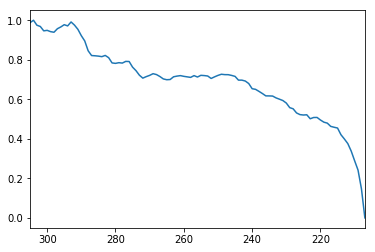

In [837]:
import matplotlib.pyplot as plt

test_var.plot()
plt.show()

In [838]:
df.head()

,database,MALE,weeks_to_death,albumin_avg,idwg_percent_avg,pre_sbp_avg,crp_avg,albumin_std,idwg_percent_std,pre_sbp_std,crp_std,albumin_count,idwg_percent_count,pre_sbp_count,crp_count,patient_count
1038,KfH-Europe,1,104,3.799071,3.073809,135.469394,19.576231,0.505016,1.645544,20.260271,29.511232,144,13552,13607,200,4754
830,RRI,1,104,3.871430,3.759100,148.908000,24.150000,0.432270,1.788500,26.539200,4.030500,126,1545,1589,2,564
518,FMC_LA,0,104,3.752380,3.178700,131.393000,NaN,0.341910,2.850800,23.224700,NaN,63,20,229,0,234
310,FMC_EUROPE,0,104,3.765270,3.266300,133.958000,8.983000,0.510960,1.745500,26.435200,16.336900,169,1909,1733,118,801
622,FMC_LA,1,104,3.888690,3.360200,135.858000,NaN,0.433980,2.060000,21.695900,NaN,84,28,310,0,322


In [839]:
instruments

,Name,Type,File,From Tempo,To Tempo,Tempo Phase,Tempo Offset,Min Var,Max Var,From Beat MS,To Beat MS
0,Clarinet C4,wind,instruments/clarinet/clarinet_C4_025_forte_nor...,1,1,28,0.0,0,100,500.0,500.0
1,Clarinet C5,wind,instruments/clarinet/clarinet_C5_025_forte_nor...,1,1,28,0.0,33,100,500.0,500.0
2,Clarinet C6,wind,instruments/clarinet/clarinet_C6_025_forte_nor...,1,1,28,0.0,66,100,500.0,500.0
3,Clarinet E4,wind,instruments/clarinet/clarinet_E4_025_forte_nor...,1,1,28,0.0,0,100,500.0,500.0
4,Clarinet E5,wind,instruments/clarinet/clarinet_E5_025_forte_nor...,1,1,28,0.0,33,100,500.0,500.0
5,Clarinet E6,wind,instruments/clarinet/clarinet_E6_025_forte_nor...,1,1,28,0.0,66,100,500.0,500.0
6,Clarinet G4,wind,instruments/clarinet/clarinet_G4_025_forte_nor...,1,1,28,0.0,0,100,500.0,500.0
7,Clarinet G5,wind,instruments/clarinet/clarinet_G5_025_forte_nor...,1,1,28,0.0,33,100,500.0,500.0
8,Clarinet E4,wind,instruments/clarinet/clarinet_E4_025_forte_nor...,1,1,28,0.5,50,100,500.0,500.0
9,Clarinet E5,wind,instruments/clarinet/clarinet_E5_025_forte_nor...,1,1,28,0.5,65,100,500.0,500.0
